In [180]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from pymc.math import exp

# Gastric Cancer Data 

Adapted from [Codes for Unit 8: gastric.odc](https://www2.isye.gatech.edu/isye6420/supporting.html).

Associated lecture video: [Unit 8 Lesson 6](https://www.youtube.com/watch?v=t4pHpZxtC0U&list=PLv0FeK5oXK4l-RdT6DWJj0_upJOG2WKNO&index=87).

Data can be found [here](https://raw.githubusercontent.com/areding/6420-pymc/main/data/gastric.csv).

Stablein et al. (1981) provide data on 90 patients affected by locally advanced, nonresectable gastric carcinoma. The patients are randomized to two treatments:
chemotherapy alone (coded as 0) and chemotherapy plus radiation (coded as 1).
Survival time is reported in days, with censoring indicator (1 = censored, 0 = observed).

Stablein, D. M., Carter, W. H., Novak, J. W. (1981). Analysis of survival data with nonproportional hazard functions. Control. Clin. Trials,  2 , 2, 149--159. 

In [14]:
data = pd.read_csv("./data/gastric.csv")

In [15]:
data

,type,censor,times
0,1,0,17.0
1,1,0,42.0
2,1,0,44.0
3,1,0,48.0
4,1,0,60.0
...,...,...,...
85,0,0,1271.0
86,0,1277,NaN
87,0,1397,NaN
88,0,1512,NaN


In [25]:
x = data["type"].to_numpy(copy=True)
censored = data["censor"].to_numpy(copy=True)
y = data["times"].to_numpy(copy=True)
y[np.isnan(y)] = censored[np.isnan(y)]

In [248]:
x

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [29]:
censored[censored == 0] = y[censored == 0] + 1

In [30]:
censored

array([  18,   43,   45,   49,   61,   73,   75,   96,  104,  109,  123,
        145,  168,  171,  184,  186,  194,  196,  198,  209,  235,  236,
        255,  308,  316,  402,  446,  465,  485,  529,  543,  568,  578,
        581,  796,  856,  882,  892, 1031, 1033, 1306, 1335, 1367, 1452,
       1472,    2,   64,  106,  130,  183,  217,  251,  263,  302,  302,
        343,  355,  357,  359,  381,  381,  384,  384,  389,  395,  409,
        461,  490,  500,  525,  529,  536,  563,  676,  677,  749,  749,
        779,  787,  798,  945,  956,  969, 1180, 1246, 1272, 1277, 1397,
       1512, 1519])

In [281]:
y.astype(int)

array([  17,   42,   44,   48,   60,   72,   74,   95,  103,  108,  122,
        144,  167,  170,  183,  185,  193,  195,  197,  208,  234,  235,
        254,  307,  315,  401,  445,  464,  484,  528,  542,  567,  577,
        580,  795,  855,  882,  892, 1031, 1033, 1306, 1335, 1366, 1452,
       1472,    1,   63,  105,  129,  182,  216,  250,  262,  301,  301,
        342,  354,  356,  358,  380,  381,  383,  383,  388,  394,  408,
        460,  489,  499,  524,  529,  535,  562,  675,  676,  748,  748,
        778,  786,  797,  945,  955,  968, 1180, 1245, 1271, 1277, 1397,
       1512, 1519])

In [255]:
np.exp(1.5)**(-1/100)

0.9998500112494375

```{warning}
PyMC and BUGS do not specify the Weibull distribution in the same way!
```

In [279]:
with pm.Model() as m:
    x_data = pm.Data("x_data", x, mutable=True)
    y_data = pm.Data("y_data", y, mutable=False)
    
    beta0 = pm.Normal("beta0", 0, sigma=10)
    beta1 = pm.Normal("beta1", 0, sigma=10)
    α = pm.Exponential("α", 0.01)

    λ = exp(beta0 + beta1 * x_data)
    β = λ ** (-1 / α)

    obs_latent = pm.Weibull("test", alpha=α, beta=β, observed=y_data)
    # likelihood = pm.Censored(
    #    "likelihood", obs_latent, lower=0, upper=censored, observed=y, shape=len(y)
    # )

    trace = pm.sample(1000, init="auto")

az.summary(trace, hdi_prob=0.9)

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'beta0': array(0.), 'beta1': array(0.), 'α_log__': array(4.60517019)}

Initial evaluation results:
{'beta0': -3.22, 'beta1': -3.22, 'α': -1.0, 'test': -inf}

In [245]:
from tqdm.auto import tqdm

values = []
for _ in tqdm(range(500)):
    beta0 = pm.draw(pm.Normal.dist(0, sigma=10))
    beta1 = pm.draw(pm.Normal.dist(0, sigma=10))
    v = pm.draw(pm.Exponential.dist(0.01))
    x0 = np.random.choice(x)
    λ = np.exp(beta0 + beta1 * x0)

    likelihood = pm.draw(pm.Weibull.dist(v, λ ** -(1 / v)))
    values.append(
        (
            round(float(beta0), 2),
            round(float(beta1), 2),
            round(float(v), 2),
            round(x0, 2),
            round(λ, 2),
            round(float(likelihood), 10),
        )
    )

vals = pd.DataFrame(values, columns=("beta0", "beta1", "v", "x0", "λ", "likelihood"))

  0%|          | 0/500 [00:00<?, ?it/s]

In [246]:
vals.describe()

,beta0,beta1,v,x0,λ,likelihood
count,500.000000,500.000000,500.000000,500.000000,5.000000e+02,5.000000e+02
mean,0.571260,-0.679380,107.754060,0.478000,1.030877e+16,1.170143e+04
std,9.873538,9.955019,102.741596,0.500016,2.033595e+17,2.616261e+05
min,-26.910000,-26.730000,0.340000,0.000000,0.000000e+00,0.000000e+00
25%,-6.532500,-7.567500,30.792500,0.000000,0.000000e+00,8.893228e-01
50%,0.895000,-0.765000,72.325000,0.000000,2.635000e+00,9.881558e-01
75%,7.582500,6.032500,155.542500,1.000000,4.745622e+03,1.091491e+00
max,32.920000,25.800000,554.340000,1.000000,4.501481e+18,5.850138e+06


In [238]:
vals

,beta0,beta1,v,x0,λ,likelihood
0,58.56,8.71,21.90,0,2.704999e+25,0.074630
1,4.29,3.32,18.94,1,2.017870e+03,0.670639
2,35.80,2.22,43.55,0,3.543164e+15,0.438529
3,-44.06,-44.39,32.10,1,0.000000e+00,14.985962
4,6.69,4.85,102.33,0,8.003400e+02,0.933407
...,...,...,...,...,...,...
995,-29.24,-28.54,21.22,1,0.000000e+00,15.219278
996,7.46,15.64,11.50,1,1.070468e+10,0.135769
997,24.07,-39.97,48.86,0,2.834368e+10,0.612771
998,-21.10,-10.80,6.96,1,0.000000e+00,87.772372


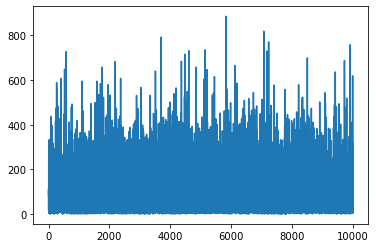

In [280]:
expo = pm.draw(pm.Exponential.dist(0.01), 10000)
plt.plot(expo)